In [58]:
from scipy import *
from matplotlib.pyplot import *
from scipy.linalg import *
from numpy.linalg import *
import scipy.sparse as sparse
import numpy as np
import pandas as pd
from scipy.sparse.linalg import splu
from timeit import default_timer as timer
import matplotlib.pyplot as plt

In [47]:
def lufact(A):
	"""
	lufact(A)

	Compute the LU factorization of square matrix A, returning the factors.
	"""
	n = A.shape[0]
	L = np.eye(n)
	U = A.copy()

	# Gaussian elimination
	for j in range(n-1):
		for i in range(j+1,n):
			L[i,j] = U[i,j] / U[j,j]   # row multiplier
			U[i,j:] = U[i,j:] - L[i,j]*U[j,j:]
	return L, np.triu(U)

def forwardsub(L,b):
	"""
 	forwardsub(L,b)

	Solve the lower-triangular linear system with matrix L and right-hand side
	vector b.
	"""
	n = len(b)
	x = np.zeros(n)
	for i in range(n):
		s = L[i,:i] @ x[:i]
		x[i] = ( b[i] - s ) / L[i,i]
	return x


def backsub(U,b):
	"""
	backsub(U,b)

	Solve the upper-triangular linear system with matrix U and right-hand side
	vector b.
	"""
	n = len(b)
	x = np.zeros(n)
	for i in range(n-1,-1,-1):
		s = U[i,i+1:] @ x[i+1:]
		x[i] = ( b[i] - s ) / U[i,i]
	return x

# T1

In [29]:
# Define the values of n
n_values = range(2, 17)

# Define the Hibert matrix given n
def hilbert_matrix(n):
    A = np.array([[ 1/(i+j+2) for j in range(n+1)] for i in range(n+1) ])
    return A

# Prepare the data
data = []

# Compute values for each n
for n in n_values:
    A = hilbert_matrix(n)
    condition_number = cond(A)
    norm_A = norm(A, 2)
    norm_A_inv = norm(inv(A), 2)
    data.append([n, condition_number, norm_A, norm_A_inv])
    
    
# Create a DataFrame to store the results
df = pd.DataFrame(data, columns=['N', 'Condition Number', 'Norm of A', 'Norm of A inverse'])

# Display the table to the user
print(df)

     N  Condition Number  Norm of A  Norm of A inverse
0    2      1.353287e+03   0.875115       1.546410e+03
1    3      4.588048e+04   0.977556       4.693385e+04
2    4      1.535044e+06   1.055949       1.453710e+06
3    5      5.109816e+07   1.118859       4.566990e+07
4    6      1.697836e+09   1.171048       1.449843e+09
5    7      5.639187e+10   1.215419       4.639706e+10
6    8      1.873544e+12   1.253859       1.494216e+12
7    9      6.230805e+13   1.287663       4.838206e+13
8   10      2.082850e+15   1.317752       1.572745e+15
9   11      5.798008e+16   1.344804       3.811817e+16
10  12      3.240859e+17   1.369333       7.851672e+16
11  13      9.782879e+17   1.391735       4.088053e+17
12  14      2.583187e+17   1.412323       1.525576e+17
13  15      3.084577e+17   1.431345       1.460217e+17
14  16      2.253333e+18   1.449006       3.765160e+17


# T2

In [37]:
# Define the values of n
n_values = [10*k for k in range(1, 8)]

# Define the Prolate matrix
def prolate_matrix(N, W):
    """
    构造一个 NxN 的 Prolate Matrix
    参数：
        N : int - 矩阵大小
        W : float - 带宽参数（0 < W < 0.5）
    返回：
        P : ndarray - Prolate matrix of shape (N, N)
    """
    P = np.zeros((N, N))
    for m in range(N):
        for n in range(N):
            if m == n:
                P[m, n] = 2 * W
            else:
                P[m, n] = np.sin(2 * np.pi * W * (m - n)) / (np.pi * (m - n))
    return P

W = 0.4

data = []
for n in n_values:
    x_exact = np.array([k/n for k in range(1, n+1)])
    A = prolate_matrix(n, W)
    b = A@x_exact
    x = solve(A, b)
    h = x - x_exact
    condition_number = cond(A)
    relative_error = norm(h, 2)/norm(x_exact, 2)
    right_handside = condition_number * (norm(h, 2)/norm(b, 2))
    data.append([n, condition_number, relative_error, right_handside])
    
# Create a DataFrame to store the results
df = pd.DataFrame(data, columns=['N', 'Condition Number', 'Relative Error', 'Right Handside'])

# Display the table to the user
print(df)

    N  Condition Number  Relative Error  Right Handside
0  10      5.661233e+01    9.323464e-16    5.337956e-14
1  20      2.078733e+04    7.409753e-13    1.549143e-08
2  30      9.801735e+06    5.204175e-10    5.120630e-03
3  40      4.983406e+09    7.189044e-09    3.592958e+01
4  50      2.631969e+12    2.560749e-05    6.755429e+07
5  60      1.488690e+15    4.145666e-02    6.183537e+13
6  70      3.269441e+16    4.101750e+00    1.343265e+17


# T3

In [48]:
# 定义矩阵 A (5x5)
def matrix_A_b(alpha, beta):
    A = np.array([
        [1, -1, 0, alpha - beta, beta],
        [0, 1, -1, 0, 0],
        [0, 0, 1, -1, 0],
        [0, 0, 0, 1, -1],
        [0, 0, 0, 0, 1]
    ])

    # 定义向量 b（5x1）
    b = np.array([
        [alpha],
        [0],
        [0],
        [0],
        [1]
    ])
    return A, b


alpha = 0.1

beta_values = [10**k for k in range(1, 13)]

data = []
for beta in beta_values:
    A, b = matrix_A_b(alpha, beta)
    condition_number = cond(A)
    L, U = lufact(A)
    y = forwardsub(L, b)
    x = backsub(U,y)
    abs_x_1 = np.abs(x[0] - 1)
    data.append([beta, abs_x_1, condition_number])

# Create a DataFrame to store the results
df = pd.DataFrame(data, columns=['Beta', '|x1 - 1|', 'Condition Number'])

# Display the table to the user
print(df)

             Beta      |x1 - 1|  Condition Number
0              10  4.440892e-16      1.604207e+02
1             100  5.773160e-15      1.426892e+04
2            1000  2.275957e-14      1.415422e+06
3           10000  3.638201e-13      1.414334e+08
4          100000  5.820788e-12      1.414226e+10
5         1000000  2.328315e-11      1.414215e+12
6        10000000  3.725291e-10      1.414214e+14
7       100000000  5.960465e-09      1.414214e+16
8      1000000000  2.384186e-08      1.414214e+18
9     10000000000  3.814697e-07      1.414214e+20
10   100000000000  6.103516e-06      1.414214e+22
11  1000000000000  2.441406e-05      1.414214e+24


C:\Users\zhufa\AppData\Local\Temp\ipykernel_16108\1863085437.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[i] = ( b[i] - s ) / L[i,i]


# T4

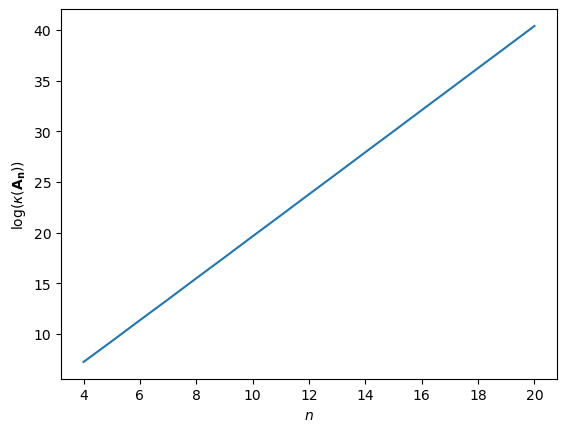

In [66]:
n_values = range(4, 21)

data = []
for n in n_values:
    t = np.array([k/n for k in range(n+1)])
    A = np.vander(t)
    condition_number = norm(A, 1) * norm(inv(A), 1)
    data.append(condition_number)
    
plt.plot(n_values, np.log(data))
plt.xlabel("$n$")
plt.ylabel("$\\log(\\kappa(\\mathbf{A_n}))$")
plt.show()

# T5

In [71]:
def matrix_A_L_U(epsilon):
    A = np.array([[-epsilon, 1], [1, -1]])
    L = np.array([[1, 0], [-1/epsilon, 1]])
    U = np.array([[-epsilon, 1], [0, 1/epsilon - 1]])
    return A, L, U

epsilon_values = [10**k for k in range(-2, -11, -1)]

data = []
for epsilon in epsilon_values:
    A, L, U = matrix_A_L_U(epsilon)
    condition_number_A = cond(A)
    condition_number_L = cond(L)
    condition_number_U = cond(U)
    data.append([epsilon, condition_number_A, condition_number_L, condition_number_U])
    
# Create a DataFrame to store the results
df = pd.DataFrame(data, columns=['epsilon', 'cond(A)', 'cond(L)', 'cond(U)'])

# Display the table to the user
print(df)

        epsilon   cond(A)       cond(L)       cond(U)
0  1.000000e-02  2.653550  1.000200e+04  9.901010e+03
1  1.000000e-03  2.621550  1.000002e+06  9.990010e+05
2  1.000000e-04  2.618385  1.000000e+08  9.999000e+07
3  1.000000e-05  2.618069  1.000000e+10  9.999900e+09
4  1.000000e-06  2.618038  1.000000e+12  9.999990e+11
5  1.000000e-07  2.618034  1.000000e+14  9.999999e+13
6  1.000000e-08  2.618034  1.000000e+16  1.000000e+16
7  1.000000e-09  2.618034  1.000000e+18  1.000000e+18
8  1.000000e-10  2.618034  9.999999e+19  1.000000e+20


# T7

In [ ]:
n_values = range(1, 1001)


cond_A_m_cond_B_list = []
cond_AB_list = []

for n in n_values:
    A = np.random.rand(n, n)
    B = np.random.rand(n, n)
    cond_AB_list.append(cond(A@B))
    cond_A_m_cond_B_list.append(cond(A)*cond(B))
    
cond_AB_list = np.array(cond_AB_list)
cond_A_m_cond_B_list = np.array(cond_A_m_cond_B_list)
relative_error_inequality = cond_AB_list/cond_A_m_cond_B_list

fig, ax = subplots(figsize=(8, 6))
ax.scatter(n_values, relative_error_inequality, c='blue', label='$\\kappa(\\mathbf{AB}) / \\kappa(\\mathbf{A})\\kappa(\\mathbf{B})$')
ax.plot(np.ones_like(relative_error_inequality), c='red', label='$y = 1$')
ax.set_ylim([0, 1.2])
ax.set_xlabel("$n$")
ax.set_title("$\\kappa(\\mathbf{AB}) / \\kappa(\\mathbf{A})\\kappa(\\mathbf{B})$ when $\\mathbf{A}, \\mathbf{B} \\in \\mathbb{R}^{n\\times n}$ (random sampling 1 time)")
ax.legend(loc='upper left')
plt.show()

In [ ]:
n_values1 = range(1, 1001)


cond_A_m_cond_B_list1 = []
cond_AB_list1 = []

for n in n_values1:
    A = np.random.rand(5, 5)
    B = np.random.rand(5, 5)
    cond_AB_list1.append(cond(A@B))
    cond_A_m_cond_B_list1.append(cond(A)*cond(B))
    
cond_AB_list1 = np.array(cond_AB_list1)
cond_A_m_cond_B_list1 = np.array(cond_A_m_cond_B_list1)
relative_error_inequality1 = cond_AB_list1/cond_A_m_cond_B_list1

fig, ax = subplots(figsize=(8, 6))
ax.scatter(n_values1, relative_error_inequality1, c='blue', label='$\\kappa(\\mathbf{AB}) / \\kappa(\\mathbf{A})\\kappa(\\mathbf{B})$')
ax.plot(np.ones_like(relative_error_inequality1), c='red', label='$y = 1$')
ax.set_ylim([0, 1.2])
ax.set_xlabel("$n$")
ax.set_title("$\\kappa(\\mathbf{AB}) / \\kappa(\\mathbf{A})\\kappa(\\mathbf{B})$ when $\\mathbf{A}, \\mathbf{B} \\in \\mathbb{R}^{5\\times 5}$ (random sampling 1000 times)")
ax.legend(loc='upper left')
plt.show()